# **Tuning Hyperparameters**

## Objectives

* Determine values of hyperparameters for Logistic Regression and an Adaptive Boost models.
* Evaluate our final models.

## Inputs

* Training and Testing datasets from notebook 04.
* Insights developed in the previous notebook.
* Pipeline from previous notebok as well as initial models.

## Outputs

* We will have saved models with tuned hyper parameters at the end of this notebook.

## Additional Comments

* We are making some philosophical assumptions about the nature of hyperparameters. The basic assumption is that the performance of a model trained with hyperparameters that are "near enough" to each other will perform "similarly enough." This is the idea that the performance of the model depends _continuously_ on the hyperparameters. We in fact assume a certain amount of regularity of this dependence. In partial differential equations (pdes), the kind of behavior we are assuming is characteristic of elliptic pdes. We do not have a technical reason for believing this. We assume this is an active area of research for various models, but in general it is outside the scope of this project. It does influence our decision in how we go about searching for good hyperparameters.


---

#### Change working directory

In [1]:
import os

home_dir = "/workspace/pp5-ml-dashboard"
os.chdir(home_dir)
current_dir = os.getcwd()
print(current_dir)

/workspace/pp5-ml-dashboard


We now load our training and test sets, as well as some of the packages that we will be using.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils import get_df, save_df

train_dir = "datasets/train/classification"
X_TrainSet = get_df("X_TrainSet", train_dir)
y_TrainSet = get_df("y_TrainSet", train_dir)

test_dir = "datasets/test/classification"
X_TestSet = get_df("X_TestSet", test_dir)
y_TestSet = get_df("y_TestSet", test_dir)

## Section 1: Pipeline and Grid Search set up
We recall the code for building our pipelines and the grid search that we performed in the last notebook. Note that some of the constants have changed. 

We have modified the pipeline to see how feateure selection impacts the performance. Note that setting `thresh=1` essentially removes the `'corr_selector'` step from the pipeline. We will eventually remove this step from the pipeline once we have selected a value for `thresh`.

In [3]:
from sklearn.preprocessing import StandardScaler
from feature_engine import transformation as vt
from feature_engine.selection import DropFeatures, SmartCorrelatedSelection
from sklearn.pipeline import Pipeline


# Constants needed for feature engineering
TO_DROP = [
    "ftm_away",
    "plus_minus_home",
    "fg3m_away",
    "pts_away",
    "play_off",
    "fgm_away",
    "pts_home",
    "fg3m_home",
    "ftm_home",
    "fgm_home",
    "season",
]
THRESH = 0.6
TRANSFORMS = {
    "box_cox": (vt.BoxCoxTransformer, False),
    "yeo_johnson": (vt.YeoJohnsonTransformer, False),
}
TRANSFORM_ASSIGNMENTS = {
    "yeo_johnson": [
        "dreb_away",
        "blk_home",
        "oreb_away",
        "fta_away",
        "dreb_home",
        "ast_home",
        "stl_away",
        "stl_home",
        "reb_away",
        "oreb_home",
        "pf_away",
        "pf_home",
    ],
    "box_cox": ["ast_away", "fta_home"],
}


def base_pipeline(thresh=THRESH):
    pipeline = Pipeline(
        [
            ("dropper", DropFeatures(features_to_drop=TO_DROP)),
            (
                "corr_selector",
                SmartCorrelatedSelection(
                    method="pearson", threshold=thresh,
                    selection_method="variance"
                ),
            ),
        ]
    )
    return pipeline


def add_transformations(pipeline, transform_assignments):
    # This needs to be called after the above is fit so that the correlation 
    # selector has that attr
    dropping = pipeline["corr_selector"].features_to_drop_

    new_assignments = {
        key: [val for val in value if val not in dropping]
        for key, value in transform_assignments.items()
    }
    for transform, targets in new_assignments.items():
        if not targets:
            continue
        pipeline.steps.append((transform, 
                               TRANSFORMS[transform][0](variables=targets)))
    pipeline.steps.append(("scaler", StandardScaler()))
    return pipeline

In [4]:
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier


MODELS = {
    "LogisticRegression": LogisticRegression,
    "AdaBoost": AdaBoostClassifier,
}


def create_pipe(model_name, random_state=42, params={}):
    model = MODELS[model_name](random_state=random_state, **params)
    base_pipe = base_pipeline()
    base_pipe.fit(X_TrainSet)
    pipe = add_transformations(base_pipe, TRANSFORM_ASSIGNMENTS)
    pipe.steps.append(("feat_selection", SelectFromModel(model)))
    pipe.steps.append(("model", model))
    pipe.name = model_name
    return pipe

Recall that our last notebook ended with selecting models with default hyperparameters and a correlation threshold of 0.6. Let's look at the baseline pipeline that results from this and see how it performs to give us an idea of where we are starting from.

In [7]:
from src.model_eval import clf_performance
import joblib


version = "v0"
file_path = f"outputs/ml_pipeline/predict_home_wins/{version}"
initial_logistic_pipe = joblib.load(filename=f"{file_path}/logistic_pipeline.pkl")

labels = ["loss", "win"]
clf_performance(
    X_TrainSet,
    y_TrainSet,
    X_TestSet,
    y_TestSet,
    initial_logistic_pipe,
    label_map=labels,
)

#### Train Set #### 

---  Confusion Matrix  ---
                Actual loss Actual win
Prediction loss       10740       2949
Prediction win         2354      18833


---  Classification Report  ---
              precision    recall  f1-score   support

        loss       0.82      0.78      0.80     13689
         win       0.86      0.89      0.88     21187

    accuracy                           0.85     34876
   macro avg       0.84      0.84      0.84     34876
weighted avg       0.85      0.85      0.85     34876
 

#### Test Set ####

---  Confusion Matrix  ---
                Actual loss Actual win
Prediction loss        2707        784
Prediction win          569       4659


---  Classification Report  ---
              precision    recall  f1-score   support

        loss       0.83      0.78      0.80      3491
         win       0.86      0.89      0.87      5228

    accuracy                           0.84      8719
   macro avg       0.84      0.83      0.84      8719
w

Next, we have the code for our grid search. As we will be treating `thresh` as a hyperparameter, it will be slightly different.

In [8]:
from sklearn.model_selection import GridSearchCV
import logging
import warnings


# to suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
logging.captureWarnings(True)
os.environ["PYTHONWARNINGS"] = "ignore"


def grid_search(X_train, y_train, pipe, param_grid={}, verbosity=1):
    print(f"### Beginning grid search for {pipe.name} ###")
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=5,
        n_jobs=-2,
        verbose=verbosity,
        scoring=["accuracy", "precision"],
        refit="precision",
    )
    grid.fit(X_train, y_train)
    return grid

## Section 2: Logistic Regression
Logistic Regression models have many hyperparameters. We will focus on:
* `penalty` is a regularization parameter.
* `solver` specifies the type of algorithm used.
* `C` controls the strength of the penalty.

Not all penalties work for each solver.

These will be our initial choice for hyperparameters. They will help us narrow down our search and find other ranges to test.

In [9]:
thresholds = [round(0.1*i,2) for i in range(5,11)]
C = [10**(2*i+1) for i in range(-2,2)]
solver = ['newton-cg', 'newton-cholesky', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['none', 'l1', 'l2', 'elasticnet']
param_grid = [
            {'C':C,
             'solver':['lbfgs','newton-cg','newton-cholesky','sag'],
             'penalty':['l2',None]},
            {'C':C,
             'solver':['liblinear'],
             'penalty':['l1','l2']},
            {'C':C,
             'solver':['saga'],
             'penalty':['l1','l2',None,'elasticnet']}
              ]
logistic_param_grid = [{'model__'+key:value 
                                for key,value in param_dict.items()}
                                for param_dict in param_grid]
for params in logistic_param_grid:
    params['corr_selector__threshold']=thresholds


Now we are ready to do the grid search. We expect this to go well since Logistic Regression was our best performing model without any tuning. This initial training will help us establish a range to further tune the hyperparamters in.

In [10]:
from src.utils import save_df, get_df


def get_grid_results_df(pipe, name, dir, param_grid={}, verbosity=2):
    try:
        results_df = get_df(name, dir)
    except FileNotFoundError:
        pipe_grid_search = grid_search(
            X_TrainSet, y_TrainSet, pipe, param_grid=param_grid, verbosity=verbosity
        )
        results_df = pd.DataFrame(pipe_grid_search.cv_results_)
        save_df(results_df, name, dir)
        # this normalizes the types
        results_df = get_df(name, dir)
    return results_df


logistic_pipe = create_pipe("LogisticRegression")
results_name = "logistic_grid_results_v1"
dir = "experiment_results/tuning/grids"

logistic_results_df_v1 = get_grid_results_df(
    logistic_pipe, results_name, dir, param_grid=logistic_param_grid
)

### Beginning grid search for LogisticRegression ###
Fitting 5 folds for each of 336 candidates, totalling 1680 fits
[CV] END corr_selector__threshold=0.5, model__C=0.001, model__penalty=l2, model__solver=lbfgs; total time=   3.9s
[CV] END corr_selector__threshold=0.5, model__C=0.001, model__penalty=l2, model__solver=newton-cg; total time=   5.5s
[CV] END corr_selector__threshold=0.5, model__C=0.001, model__penalty=l2, model__solver=sag; total time=   6.0s
[CV] END corr_selector__threshold=0.5, model__C=0.001, model__penalty=l2, model__solver=lbfgs; total time=   4.2s
[CV] END corr_selector__threshold=0.5, model__C=0.001, model__penalty=l2, model__solver=newton-cg; total time=   4.3s
[CV] END corr_selector__threshold=0.5, model__C=0.001, model__penalty=l2, model__solver=sag; total time=   3.9s
[CV] END corr_selector__threshold=0.5, model__C=0.001, model__penalty=l2, model__solver=newton-cholesky; total time=   5.7s
[CV] END corr_selector__threshold=0.5, model__C=0.001, model__penalty=N


Let's look at what the best choices are at this stage.

In [11]:
from src.model_eval import get_best_params_df

get_best_params_df(logistic_results_df_v1)

Best parameters for current model:
threshold: 0.8
C: 10
penalty: l2
solver: lbfgs
Avg. Precision: 88.70480236491775%.
Avg. Accuracy: 87.18030112459309%.

threshold: 0.8
C: 10
penalty: l2
solver: newton-cg
Avg. Precision: 88.70480236491775%.
Avg. Accuracy: 87.18030112459309%.

threshold: 0.8
C: 1000
penalty: l2
solver: lbfgs
Avg. Precision: 88.70480236491775%.
Avg. Accuracy: 87.18030112459309%.



Clearly, the best correlation threshold is 0.8. The models have the same scores. Lets collect all of the parameters that have the same scores. We order the scores not by count but by score.

In [12]:
from src.model_eval import present_score_counts, score_stats

present_score_counts(logistic_results_df_v1)
best_score = score_stats(logistic_results_df_v1)

---  Score Counts  ---
Precision: 0.8870480236491776, Accuracy: 0.8718030112459308
Count: 12

Precision: 0.887042467962182, Accuracy: 0.8717743374108053
Count: 2

Precision: 0.8870152603635608, Accuracy: 0.8718030194666403
Count: 1

Precision: 0.8869924718004393, Accuracy: 0.8718890245305975
Count: 1

---  Score Stats  ---
Most Common: Precision: -1
             Accuracy: -1
             Count: 196
Max Score: Precision: 0.8870480236491776
           Accuracy: 0.8718030112459308
           Count: 12
Max Precision: 0.8870480236491776
Max Accuracy: 0.871917694255368


The most common scores are `nan` (we changed the score to be -1 if a `nan` value was showing up). This happens when a choice of parameters does not work well together. We won't worry about this as we are able to get quite good precision and accuracy with this first pass. Note that the best accuracy score is not far from the accuracy of the model with the best precision.

12 different choices of parameters had the best performance. We would like to see what these estimators had in common and look at neighborhoods around these parameters to see if we can improve the performance before moving on to the next model.

In [13]:
from src.model_eval import present_param_counts

present_param_counts(logistic_results_df_v1, best_score)

model__solver: saga, Count: 4
model__solver: liblinear, Count: 3
model__solver: lbfgs, Count: 2
model__solver: newton-cg, Count: 2
model__solver: sag, Count: 1
model__penalty: l2, Count: 8
model__penalty: l1, Count: 4
model__C: 1000, Count: 7
model__C: 10, Count: 5
corr_selector__threshold: 0.8, Count: 12


We will make the following modifications to `logistic_param_grid`:
* remove `'newton-cholesky'` and `'sag'` as they were used the least,
* pick a neighborhood around 0.8 for correlation threshold,
* focus on penalties `'l2'` and `'None'`
* focus on the range 10 to 1000 for `C`

We will see if focusing gives us any improvement in score.

In [15]:
from src.utils import divide_range

thresholds = divide_range(0.75, 0.85, 5)
C = divide_range(8, 1000, 6)
logistic_param_grid_v2 = [
    {
        "model__C": C,
        "model__solver": ["lbfgs", "newton-cg", "saga"],
        "model__penalty": ["l2", None],
        "corr_selector__threshold": thresholds,
    },
    {
        "model__C": C,
        "model__solver": ["liblinear"],
        "model__penalty": ["l2"],
        "corr_selector__threshold": thresholds,
    },
]

In [16]:
logistic_results_df_v2 = get_grid_results_df(
    logistic_pipe,
    "logistic_results_df_v2",
    dir,
    param_grid=logistic_param_grid_v2,
    verbosity=3,
)

### Beginning grid search for LogisticRegression ###
Fitting 5 folds for each of 294 candidates, totalling 1470 fits


[CV 1/5] END corr_selector__threshold=0.75, model__C=8.0, model__penalty=None, model__solver=lbfgs; accuracy: (test=nan) precision: (test=nan) total time=   7.1s
[CV 2/5] END corr_selector__threshold=0.75, model__C=8.0, model__penalty=l2, model__solver=lbfgs; accuracy: (test=0.841) precision: (test=0.858) total time=   7.8s
[CV 3/5] END corr_selector__threshold=0.75, model__C=8.0, model__penalty=l2, model__solver=newton-cg; accuracy: (test=0.846) precision: (test=0.861) total time=   8.1s
[CV 3/5] END corr_selector__threshold=0.75, model__C=8.0, model__penalty=None, model__solver=newton-cg; accuracy: (test=nan) precision: (test=nan) total time=   7.3s
[CV 3/5] END corr_selector__threshold=0.75, model__C=8.0, model__penalty=l2, model__solver=saga; accuracy: (test=0.846) precision: (test=0.861) total time=   9.2s
[CV 2/5] END corr_selector__threshold=0.75, model__C=8.0, model__penalty=None, model__solver=newton-cg; accuracy: (test=nan) precision: (test=nan) total time=   7.7s
[CV 4/5] EN

Let's proceed by doing the analysis we did above of the results of this grid search.

In [17]:
get_best_params_df(logistic_results_df_v2)

Best parameters for current model:
threshold: 0.77
C: 8.0
penalty: l2
solver: lbfgs
Avg. Precision: 88.70480236491775%.
Avg. Accuracy: 87.18030112459309%.

threshold: 0.77
C: 8.0
penalty: l2
solver: newton-cg
Avg. Precision: 88.70480236491775%.
Avg. Accuracy: 87.18030112459309%.

threshold: 0.77
C: 173.333
penalty: l2
solver: lbfgs
Avg. Precision: 88.70480236491775%.
Avg. Accuracy: 87.18030112459309%.



Again, very similar scores. So let's analyze the scores that showed up as we did before.

In [18]:
present_score_counts(logistic_results_df_v2)
best_score = score_stats(logistic_results_df_v2)

---  Score Counts  ---
Precision: 0.8870480236491776, Accuracy: 0.8718030112459308
Count: 78

Precision: 0.887042467962182, Accuracy: 0.8717743374108053
Count: 6

Precision: 0.8753149006289227, Accuracy: 0.8584414808786294
Count: 36

Precision: 0.875274772243287, Accuracy: 0.8584128070435041
Count: 12

---  Score Stats  ---
Most Common: Precision: -1
             Accuracy: -1
             Count: 126
Max Score: Precision: 0.8870480236491776
           Accuracy: 0.8718030112459308
           Count: 78
Max Precision: 0.8870480236491776
Max Accuracy: 0.8718030112459308


Our best score is even more common now. It seems like we have chosen a good range of parameters since many of the combinations yield good results. This does make it harder to narrow down the search though.

In [19]:
present_param_counts(logistic_results_df_v2, best_score)

model__solver: lbfgs, Count: 21
model__solver: newton-cg, Count: 21
model__solver: saga, Count: 18
model__solver: liblinear, Count: 18
model__penalty: l2, Count: 78
model__C: 173.333, Count: 12
model__C: 338.667, Count: 12
model__C: 504.0, Count: 12
model__C: 669.333, Count: 12
model__C: 834.667, Count: 12
model__C: 1000.0, Count: 12
model__C: 8.0, Count: 6
corr_selector__threshold: 0.77, Count: 26
corr_selector__threshold: 0.79, Count: 26
corr_selector__threshold: 0.81, Count: 26


All of the choices of parameters seem to be performing equally well, with some exceptioins. We will only focus on the loss function `'l2'`, and narrow the bounds on `'threshold'` and `C`. We will increase the number of options for these ranges as the time taken for the grid search is still reasonable.

In [25]:
from src.utils import divide_range

thresholds = divide_range(0.75, 0.85, 8)
C = divide_range(10, 1000, 8)
logistic_param_grid_v3 = [
    {
        "model__C": C,
        "model__solver": ["lbfgs", "liblinear", "newton-cg", "saga"],
        "model__penalty": ["l2"],
        "corr_selector__threshold": thresholds,
    }
]

In [26]:
logistic_results_df_v3 = get_grid_results_df(
    logistic_pipe,
    "logistic_results_df_v3",
    dir, 
    param_grid=logistic_param_grid_v3,
    verbosity=3,
)

### Beginning grid search for LogisticRegression ###
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[CV 2/5] END corr_selector__threshold=0.75, model__C=10.0, model__penalty=l2, model__solver=newton-cg; accuracy: (test=0.841) precision: (test=0.858) total time=   7.0s
[CV 3/5] END corr_selector__threshold=0.75, model__C=10.0, model__penalty=l2, model__solver=liblinear; accuracy: (test=0.846) precision: (test=0.861) total time=   8.2s
[CV 4/5] END corr_selector__threshold=0.75, model__C=10.0, model__penalty=l2, model__solver=newton-cg; accuracy: (test=0.849) precision: (test=0.869) total time=   8.5s
[CV 1/5] END corr_selector__threshold=0.75, model__C=10.0, model__penalty=l2, model__solver=newton-cg; accuracy: (test=0.848) precision: (test=0.865) total time=   9.3s
[CV 4/5] END corr_selector__threshold=0.75, model__C=133.75, model__penalty=l2, model__solver=liblinear; accuracy: (test=0.849) precision: (test=0.869) total time=   6.8s
[CV 5/5] END corr_selector__threshold=0.75, model__C=10.0, model__penalty=l2, model__solver=lbfgs; accuracy: (test=0.854) precision: (test=0.870) total t

In [27]:
present_score_counts(logistic_results_df_v3)
best_score = score_stats(logistic_results_df_v3)

---  Score Counts  ---
Precision: 0.8870480236491776, Accuracy: 0.8718030112459308
Count: 105

Precision: 0.887042467962182, Accuracy: 0.8717743374108053
Count: 3

Precision: 0.8814979372252573, Accuracy: 0.8659539311433363
Count: 3

Precision: 0.8814923815382618, Accuracy: 0.8659252573082108
Count: 1

---  Score Stats  ---
Most Common: Precision: 0.8870480236491776
             Accuracy: 0.8718030112459308
             Count: 105
Max Score: Precision: 0.8870480236491776
           Accuracy: 0.8718030112459308
           Count: 105
Max Precision: 0.8870480236491776
Max Accuracy: 0.8718030112459308


It is becoming difficult to distinguish between different combinations of parameters.

In [28]:
present_param_counts(logistic_results_df_v3, best_score)

model__solver: lbfgs, Count: 27
model__solver: newton-cg, Count: 27
model__solver: saga, Count: 27
model__solver: liblinear, Count: 24
model__penalty: l2, Count: 105
model__C: 133.75, Count: 12
model__C: 257.5, Count: 12
model__C: 381.25, Count: 12
model__C: 505.0, Count: 12
model__C: 628.75, Count: 12
model__C: 752.5, Count: 12
model__C: 876.25, Count: 12
model__C: 1000.0, Count: 12
model__C: 10.0, Count: 9
corr_selector__threshold: 0.775, Count: 35
corr_selector__threshold: 0.787, Count: 35
corr_selector__threshold: 0.8, Count: 35


Things have narrowed a bit.

In [29]:
from src.utils import divide_range

thresholds = divide_range(0.77, 0.81, 8)
C = divide_range(70, 1000, 8)
logistic_param_grid_v4 = [
    {
        "model__C": C,
        "model__solver": ["lbfgs", "liblinear", "newton-cg", "saga"],
        "model__penalty": ["l2"],
        "corr_selector__threshold": thresholds,
    }
]

logistic_results_df_v4 = get_grid_results_df(
    logistic_pipe,
    "logistic_results_df_v4",
    dir,
    param_grid=logistic_param_grid_v4,
    verbosity=3,
)

### Beginning grid search for LogisticRegression ###
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV 3/5] END corr_selector__threshold=0.77, model__C=70.0, model__penalty=l2, model__solver=lbfgs; accuracy: (test=0.872) precision: (test=0.885) total time=   5.8s
[CV 3/5] END corr_selector__threshold=0.77, model__C=186.25, model__penalty=l2, model__solver=liblinear; accuracy: (test=0.872) precision: (test=0.885) total time=   8.0s
[CV 5/5] END corr_selector__threshold=0.77, model__C=70.0, model__penalty=l2, model__solver=lbfgs; accuracy: (test=0.878) precision: (test=0.895) total time=   8.1s
[CV 2/5] END corr_selector__threshold=0.77, model__C=70.0, model__penalty=l2, model__solver=liblinear; accuracy: (test=0.866) precision: (test=0.879) total time=   8.5s
[CV 1/5] END corr_selector__threshold=0.77, model__C=186.25, model__penalty=l2, model__solver=lbfgs; accuracy: (test=0.870) precision: (test=0.885) total time=   8.5s
[CV 2/5] END corr_selector__threshold=0.77, mo

In [30]:
present_score_counts(logistic_results_df_v4)
best_score = score_stats(logistic_results_df_v4)

---  Score Counts  ---
Precision: 0.8870480236491776, Accuracy: 0.8718030112459308
Count: 324

---  Score Stats  ---
Most Common: Precision: 0.8870480236491776
             Accuracy: 0.8718030112459308
             Count: 324
Max Score: Precision: 0.8870480236491776
           Accuracy: 0.8718030112459308
           Count: 324
Max Precision: 0.8870480236491776
Max Accuracy: 0.8718030112459308


The scores are not improving meaningfully and the number of combinations with the same performance is increasing.

In [31]:
present_param_counts(logistic_results_df_v4, best_score)

model__solver: lbfgs, Count: 81
model__solver: liblinear, Count: 81
model__solver: newton-cg, Count: 81
model__solver: saga, Count: 81
model__penalty: l2, Count: 324
model__C: 70.0, Count: 36
model__C: 186.25, Count: 36
model__C: 302.5, Count: 36
model__C: 418.75, Count: 36
model__C: 535.0, Count: 36
model__C: 651.25, Count: 36
model__C: 767.5, Count: 36
model__C: 883.75, Count: 36
model__C: 1000.0, Count: 36
corr_selector__threshold: 0.77, Count: 36
corr_selector__threshold: 0.775, Count: 36
corr_selector__threshold: 0.78, Count: 36
corr_selector__threshold: 0.785, Count: 36
corr_selector__threshold: 0.79, Count: 36
corr_selector__threshold: 0.795, Count: 36
corr_selector__threshold: 0.8, Count: 36
corr_selector__threshold: 0.805, Count: 36
corr_selector__threshold: 0.81, Count: 36


All of the choices are divided completely evenly.



We will have to look at other metrics to determine distinguish between these choices of parameters. Things such as training time statistics, and standard deviation of the scores.

In [35]:
best_results = logistic_results_df_v4.query(
    f"mean_test_precision == {best_score[0]} and mean_test_accuracy == {best_score[1]}"
)
std_score_counts = {}

for _, row in best_results.iterrows():
    std_score = (row["std_test_precision"], row["std_test_accuracy"])
    if std_score in std_score_counts:
        std_score_counts[std_score] += 1
    else:
        std_score_counts[std_score] = 1
for key, value in std_score_counts.items():
    print(
        f"std_test_precision: {key[0]} \n"
        f"std_test_accuracy: {key[1]} \n"
        f"count: {value}"
    )

std_test_precision: 0.0054844417109899 
std_test_accuracy: 0.004118208175772 
count: 324


In [36]:
std_test_precision_values = best_results["std_test_precision"].unique()
best_std_precision = max(std_test_precision_values)
best_results = best_results.query(f"std_test_precision == {best_std_precision}")
std_test_accuracy_values = best_results["std_test_accuracy"].unique()
best_std_accuracy = max(std_test_accuracy_values)
best_results = best_results.query(f"std_test_accuracy == {best_std_accuracy}")
present_param_counts(best_results, best_score)

model__solver: lbfgs, Count: 81
model__solver: liblinear, Count: 81
model__solver: newton-cg, Count: 81
model__solver: saga, Count: 81
model__penalty: l2, Count: 324
model__C: 70.0, Count: 36
model__C: 186.25, Count: 36
model__C: 302.5, Count: 36
model__C: 418.75, Count: 36
model__C: 535.0, Count: 36
model__C: 651.25, Count: 36
model__C: 767.5, Count: 36
model__C: 883.75, Count: 36
model__C: 1000.0, Count: 36
corr_selector__threshold: 0.77, Count: 36
corr_selector__threshold: 0.775, Count: 36
corr_selector__threshold: 0.78, Count: 36
corr_selector__threshold: 0.785, Count: 36
corr_selector__threshold: 0.79, Count: 36
corr_selector__threshold: 0.795, Count: 36
corr_selector__threshold: 0.8, Count: 36
corr_selector__threshold: 0.805, Count: 36
corr_selector__threshold: 0.81, Count: 36


So standard deviation will not help us distinguish either. This is annoying, but good. We will see how the models perform on the test dataset.

Note: If you are tinkering and running cells multiple times, we recommend commenting out the code in the following three cells. They take a bit even after they have already been run the first time since we aren't saving the large number of pipelines and models.

In [39]:
import ast


def parameter_dicts(results_df, best_score):
    relevant = results_df.query(
        f"mean_test_precision == {best_score[0]} and mean_test_accuracy == {best_score[1]}"
    )
    param_dicts = [
        ast.literal_eval(param_dict) for param_dict in relevant["params"].values
    ]
    return param_dicts


best_params = parameter_dicts(logistic_results_df_v4, best_score)

best_pipes = []
for param_dict in best_params:
    base_pipe = create_pipe("LogisticRegression")
    pipe = base_pipe.set_params(**param_dict)
    pipe.param_dict = param_dict
    best_pipes.append(pipe)

model_params = {key.split("__")[0]: key.split("__")[1] for key in best_params[0].keys()}
"""
count = 0
for pipe in best_pipes:
    print(f"Pipe {count}:")
    for step in pipe.get_params()['steps']:
        if step[0] in model_params:
            param = model_params[step[0]]
            value = step[1].get_params()[param]
            print(f"{step[0]}"
                  f"\n{param}: {value}")
    print()
    count += 1
    if count>=2:
        break
    """

'\ncount = 0\nfor pipe in best_pipes:\n    print(f"Pipe {count}:")\n    for step in pipe.get_params()[\'steps\']:\n        if step[0] in model_params:\n            param = model_params[step[0]]\n            value = step[1].get_params()[param]\n            print(f"{step[0]}"\n                  f"\n{param}: {value}")\n    print()\n    count += 1\n    if count>=2:\n        break\n    '

We will now train all of the above pipelines and evaluate them on the test dataset.

In [40]:
count = 0
for pipe in best_pipes:
    print(f"Training pipe {count}:")
    print(pipe.param_dict)
    pipe.fit(X_TrainSet, y_TrainSet)
    count+=1


Training pipe 0:
{'corr_selector__threshold': 0.77, 'model__C': 70.0, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Training pipe 1:
{'corr_selector__threshold': 0.77, 'model__C': 70.0, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Training pipe 2:
{'corr_selector__threshold': 0.77, 'model__C': 70.0, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Training pipe 3:
{'corr_selector__threshold': 0.77, 'model__C': 70.0, 'model__penalty': 'l2', 'model__solver': 'saga'}
Training pipe 4:
{'corr_selector__threshold': 0.77, 'model__C': 186.25, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Training pipe 5:
{'corr_selector__threshold': 0.77, 'model__C': 186.25, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Training pipe 6:
{'corr_selector__threshold': 0.77, 'model__C': 186.25, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Training pipe 7:
{'corr_selector__threshold': 0.77, 'model__C': 186.25, 'model__penalty': 'l2', 'model__solver': 'saga'}
Training pipe 8:
{

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def evaluate_param_on_test_set(pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return ((precision, accuracy, recall, f1), pipe.param_dict)


def evaluate_and_sort(fitted_pipes, X_test, y_test):
    evaluations = [
        evaluate_param_on_test_set(pipe, X_test, y_test) 
        for pipe in fitted_pipes
    ]
    evaluation_dict = {}
    for eval in evaluations:
        if eval[0] in evaluation_dict:
            evaluation_dict[eval[0]].append(eval[1])
        else:
            evaluation_dict[eval[0]] = [eval[1]]
    sorted_eval_dict = {
        k: v
        for k, v in sorted(
            evaluation_dict.items(), key=lambda item: item[0], reverse=True
        )
    }
    return sorted_eval_dict


sorted_evals = evaluate_and_sort(best_pipes, X_TestSet, y_TestSet)
print(len(sorted_evals))
for key, value in sorted_evals.items():
    print(f"{key} \n{len(value)}")

1
(0.8791025403300575, 0.8693657529533203, 0.9068477429227237, 0.892759627153752) 
324


It turns out that all of these best sets of parameters produce models that perform equally well with respect to the standard metrics. We will have to pick one to deploy. We will look at the time it took to score each model during the grid search.

In [43]:
time_results = best_results.filter(['mean_score_time','std_score_time','params'])

time_results = time_results.sort_values(by=['mean_score_time','std_score_time'])
print(time_results.head())
params_choice = time_results.iloc[0]['params']
print(params_choice)


       mean_score_time  std_score_time  \
Index                                    
322           0.030526        0.036447   
323           0.039618        0.034294   
319           0.177837        0.073100   
321           0.196406        0.122617   
303           0.202415        0.085132   

                                                  params  
Index                                                     
322    {'corr_selector__threshold': 0.81, 'model__C':...  
323    {'corr_selector__threshold': 0.81, 'model__C':...  
319    {'corr_selector__threshold': 0.81, 'model__C':...  
321    {'corr_selector__threshold': 0.81, 'model__C':...  
303    {'corr_selector__threshold': 0.81, 'model__C':...  
{'corr_selector__threshold': 0.81, 'model__C': 1000.0, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}


We have the following choice of hyperparameters:
* correlation threshold: 0.81
* `C`: 1000
* solver method: newton-cg
* penalty function: l2

Let's train the model and then look at the classification report. We don't need to list the penalty function since l2 is the default penalty function.

In [44]:
from src.model_eval import clf_performance

model_params = {'C':1000, 'solver': 'newton-cg'}

logistic_pipe = create_pipe(model_name='LogisticRegression', params=model_params)
logistic_pipe.set_params(corr_selector__threshold=0.81)
logistic_pipe.fit(X_TrainSet, y_TrainSet)

clf_performance(X_TrainSet, y_TrainSet, X_TestSet, y_TestSet, logistic_pipe, label_map=['loss','win'])

#### Train Set #### 

---  Confusion Matrix  ---
                Actual loss Actual win
Prediction loss       11253       2436
Prediction win         2022      19165


---  Classification Report  ---
              precision    recall  f1-score   support

        loss       0.85      0.82      0.83     13689
         win       0.89      0.90      0.90     21187

    accuracy                           0.87     34876
   macro avg       0.87      0.86      0.87     34876
weighted avg       0.87      0.87      0.87     34876
 

#### Test Set ####

---  Confusion Matrix  ---
                Actual loss Actual win
Prediction loss        2839        652
Prediction win          487       4741


---  Classification Report  ---
              precision    recall  f1-score   support

        loss       0.85      0.81      0.83      3491
         win       0.88      0.91      0.89      5228

    accuracy                           0.87      8719
   macro avg       0.87      0.86      0.86      8719
w

The performance on the training and test data is similar which means that our model is generalizing well. We are hapy with these scores.

Let's now see the importance of the different features according to our final model.

* These are the 8 most important features in descending order. The model was trained on them: 
['dreb_home', 'dreb_away', 'tov_away', 'tov_home', 'fta_home', 'fta_away', 'ast_home', 'ast_away']
fta_home 5.88863110488404
dreb_home 13.260014471667512
ast_home 5.295541590643584
tov_home -6.8729694992106065
fta_away -5.443416614685196
dreb_away -13.186730202624586
ast_away -4.631039714664695
tov_away 7.690202521281905


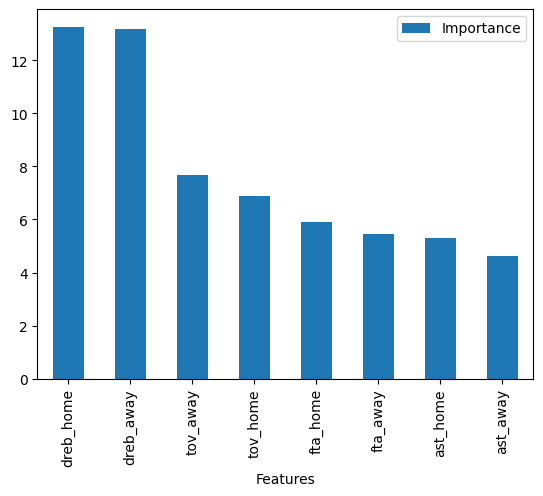

In [45]:
from src.notebook_functions import feature_importance_logistic_regression


feature_importance_logistic_regression(logistic_pipe, 'model', X_TrainSet, TO_DROP)

According to our logistic model, defensive rebounds and turn overs are the most important features for predicting who will win when point related features are removed.


In [47]:
stats = ['dreb','tov','ast','fta']
home_features = [term+'_home' for term in stats]
away_features = [term+'_away' for term in stats]
features = home_features + away_features
to_drop = [feature for feature in X_TrainSet.columns 
           if feature not in features]

TRANSFORMS = {'box_cox':(vt.BoxCoxTransformer,False),
              'yeo_johnson':(vt.YeoJohnsonTransformer,False)}
TRANSFORM_ASSIGNMENTS = {
    'yeo_johnson': ['dreb_away', 'blk_home', 'oreb_away', 'fta_away',
                    'dreb_home', 'ast_home', 'stl_away', 'stl_home',
                    'reb_away', 'oreb_home', 'pf_away', 'pf_home'],
    'box_cox': ['ast_away', 'fta_home']
                            }


new_assignments = { key: [val for val in value if val not in to_drop] 
                       for key,value in TRANSFORM_ASSIGNMENTS.items()}
   
final_logistic_pipe = Pipeline([
        ('dropper', DropFeatures(features_to_drop=TO_DROP))])
        
for transform, targets in new_assignments.items():
    if not targets:
        continue
    final_logistic_pipe.steps.append(
            (transform, TRANSFORMS[transform][0](variables=targets))
            )
final_logistic_pipe.steps.append(('scaler', StandardScaler()))
final_logistic_pipe.steps.append(('model',LogisticRegression(C=1000, 
                                        solver='newton-cg', random_state=42)))

Now we fit and evaluate it.

In [48]:
final_logistic_pipe.fit(X_TrainSet, y_TrainSet)
clf_performance(X_TrainSet, y_TrainSet, X_TestSet, y_TestSet, final_logistic_pipe, label_map=['loss','win'])

#### Train Set #### 

---  Confusion Matrix  ---
                Actual loss Actual win
Prediction loss       11401       2288
Prediction win         1922      19265


---  Classification Report  ---
              precision    recall  f1-score   support

        loss       0.86      0.83      0.84     13689
         win       0.89      0.91      0.90     21187

    accuracy                           0.88     34876
   macro avg       0.87      0.87      0.87     34876
weighted avg       0.88      0.88      0.88     34876
 

#### Test Set ####

---  Confusion Matrix  ---
                Actual loss Actual win
Prediction loss        2886        605
Prediction win          450       4778


---  Classification Report  ---
              precision    recall  f1-score   support

        loss       0.87      0.83      0.85      3491
         win       0.89      0.91      0.90      5228

    accuracy                           0.88      8719
   macro avg       0.88      0.87      0.87      8719
w

Unsurprisingly, the performance remains quite good. Now on to AdaBoost.

## Section 3: Adaptive Boost
We will now do a grid search with an Adaptive Boost model. After an initial search to determine a range, we will investigate more closely.

First, let's look at how the model performs with the default parameters.


In [49]:
version = "v0"
file_path = f"outputs/ml_pipeline/predict_home_wins/{version}"
initial_ada_pipe = joblib.load(filename=f"{file_path}/ada_pipeline.pkl")

labels = ["loss", "win"]
clf_performance(
    X_TrainSet, y_TrainSet, X_TestSet, y_TestSet, initial_ada_pipe,
    label_map=labels
)

#### Train Set #### 

---  Confusion Matrix  ---
                Actual loss Actual win
Prediction loss        9876       3813
Prediction win         2259      18928


---  Classification Report  ---
              precision    recall  f1-score   support

        loss       0.81      0.72      0.76     13689
         win       0.83      0.89      0.86     21187

    accuracy                           0.83     34876
   macro avg       0.82      0.81      0.81     34876
weighted avg       0.83      0.83      0.82     34876
 

#### Test Set ####

---  Confusion Matrix  ---
                Actual loss Actual win
Prediction loss        2504        987
Prediction win          547       4681


---  Classification Report  ---
              precision    recall  f1-score   support

        loss       0.82      0.72      0.77      3491
         win       0.83      0.90      0.86      5228

    accuracy                           0.82      8719
   macro avg       0.82      0.81      0.81      8719
w



With AdaBoost, there are two types of parameters. We have parameters for AdaBoost.

AdaBoost has the following hyperparameters.
* `n_estimators` the max number of estimators
* `learning_rate` which weights the estimators
* `algorithm` of which there are two choices

In [50]:
ada_params = [
    {
        "corr_selector__threshold": divide_range(0.55, 0.95, 3),
        "model__n_estimators": [int(i) for i in divide_range(20, 50, 3)],
        "model__learning_rate": divide_range(0.5, 2, 3),
        "model__algorithm": ["SAMME", "SAMME.R"],
    }
]

In [51]:
ada_pipe = create_pipe('AdaBoost')
ada_results_df_v1 = get_grid_results_df(ada_pipe,'ada_results_df_v1', dir, 
                                             param_grid=ada_params)


### Beginning grid search for AdaBoost ###
Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV] END corr_selector__threshold=0.55, model__algorithm=SAMME, model__learning_rate=0.5, model__n_estimators=50; total time=   3.4s
[CV] END corr_selector__threshold=0.55, model__algorithm=SAMME, model__learning_rate=0.5, model__n_estimators=30; total time=   3.1s
[CV] END corr_selector__threshold=0.55, model__algorithm=SAMME, model__learning_rate=0.5, model__n_estimators=20; total time=   3.2s
[CV] END corr_selector__threshold=0.55, model__algorithm=SAMME, model__learning_rate=0.5, model__n_estimators=20; total time=   3.0s
[CV] END corr_selector__threshold=0.55, model__algorithm=SAMME, model__learning_rate=1.0, model__n_estimators=30; total time=   2.5s
[CV] END corr_selector__threshold=0.55, model__algorithm=SAMME, model__learning_rate=0.5, model__n_estimators=20; total time=   3.0s
[CV] END corr_selector__threshold=0.55, model__algorithm=SAMME, model__learning_rate=1.0, model_

Let's see what the top scores are.

In [52]:
present_score_counts(ada_results_df_v1)
best_score_v1 = score_stats(ada_results_df_v1)

---  Score Counts  ---
Precision: 0.8664772614234539, Accuracy: 0.8500976538094769
Count: 1

Precision: 0.8659743228971937, Accuracy: 0.8490653957449608
Count: 1

Precision: 0.8656983077474066, Accuracy: 0.8444489904968597
Count: 1

Precision: 0.8622546188710796, Accuracy: 0.8413808901384368
Count: 1

---  Score Stats  ---
Most Common: Precision: -1
             Accuracy: -1
             Count: 32
Max Score: Precision: 0.8664772614234539
           Accuracy: 0.8500976538094769
           Count: 1
Max Precision: 0.8664772614234539
Max Accuracy: 0.8500976538094769


Let's look at the parameters associated with the top 5 scores.

In [53]:
from src.model_eval import collect_like_estimators

def top_n(results_df,num=5,exclude=None):
    estimators_by_score = collect_like_estimators(results_df)
    scores = list(estimators_by_score.keys())
    top = sorted(scores,reverse=True)[:num]
    for score in top:
        print(f"Score: {score}")
        present_param_counts(results_df, score, exclude)

top_n(ada_results_df_v1)

Score: (0.8664772614234539, 0.8500976538094769)
model__n_estimators: 50, Count: 1
model__learning_rate: 1.0, Count: 1
model__algorithm: SAMME.R, Count: 1
corr_selector__threshold: 0.95, Count: 1
Score: (0.8659743228971937, 0.8490653957449608)
model__n_estimators: 50, Count: 1
model__learning_rate: 1.0, Count: 1
model__algorithm: SAMME.R, Count: 1
corr_selector__threshold: 0.817, Count: 1
Score: (0.8656983077474066, 0.8444489904968597)
model__n_estimators: 50, Count: 1
model__learning_rate: 1.5, Count: 1
model__algorithm: SAMME.R, Count: 1
corr_selector__threshold: 0.95, Count: 1
Score: (0.8622546188710796, 0.8413808901384368)
model__n_estimators: 50, Count: 1
model__learning_rate: 1.5, Count: 1
model__algorithm: SAMME.R, Count: 1
corr_selector__threshold: 0.817, Count: 1
Score: (0.8620041964216935, 0.8457393665121172)
model__n_estimators: 40, Count: 1
model__learning_rate: 1.0, Count: 1
model__algorithm: SAMME.R, Count: 1
corr_selector__threshold: 0.95, Count: 1


This gives us an idea of how to narrow down our hyperparameters.
* More estimators is better.
* We will use the algorithm `'SAMME.R'`.
* Learning rate near 1 is good
* We will focus on a range of correlation threshold from 0.8 to 0.95

In [54]:
ada_pipe.set_params(model__algorithm='SAMME.R')
ada_params_v2 = [{'corr_selector__threshold': divide_range(0.8,0.95,3),
'model__n_estimators':[int(i) for i in divide_range(40,80,3)],
'model__learning_rate': divide_range(0.8,1.5,3),}]

In [55]:
ada_results_df_v2 = get_grid_results_df(ada_pipe,'ada_results_df_v2',
                                             dir, param_grid=ada_params_v2,
                                             verbosity=3)

### Beginning grid search for AdaBoost ###
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END corr_selector__threshold=0.8, model__learning_rate=1.033, model__n_estimators=40; accuracy: (test=0.847) precision: (test=0.861) total time=  38.0s
[CV 1/5] END corr_selector__threshold=0.8, model__learning_rate=0.8, model__n_estimators=40; accuracy: (test=0.844) precision: (test=0.857) total time=  41.5s
[CV 4/5] END corr_selector__threshold=0.8, model__learning_rate=0.8, model__n_estimators=40; accuracy: (test=0.851) precision: (test=0.865) total time=  41.8s
[CV 4/5] END corr_selector__threshold=0.8, model__learning_rate=1.033, model__n_estimators=53; accuracy: (test=0.863) precision: (test=0.882) total time=  39.2s
[CV 3/5] END corr_selector__threshold=0.8, model__learning_rate=0.8, model__n_estimators=40; accuracy: (test=0.847) precision: (test=0.856) total time=  41.4s
[CV 4/5] END corr_selector__threshold=0.8, model__learning_rate=1.033, model__n_estimators=40; a

In [57]:
top_n(ada_results_df_v2,6)

Score: (0.878885158961508, 0.8621116618986552)
model__n_estimators: 80, Count: 1
model__learning_rate: 1.033, Count: 1
corr_selector__threshold: 0.8, Count: 1
Score: (0.877798938119638, 0.8596457244089312)
model__n_estimators: 80, Count: 1
model__learning_rate: 1.267, Count: 1
corr_selector__threshold: 0.8, Count: 1
Score: (0.8770133758415453, 0.8586708016836013)
model__n_estimators: 66, Count: 1
model__learning_rate: 1.267, Count: 1
corr_selector__threshold: 0.8, Count: 1
Score: (0.8769633783106618, 0.85941638716254)
model__n_estimators: 80, Count: 1
model__learning_rate: 1.5, Count: 1
corr_selector__threshold: 0.8, Count: 1
Score: (0.8768317562019001, 0.8636600078918812)
model__n_estimators: 80, Count: 1
model__learning_rate: 0.8, Count: 1
corr_selector__threshold: 0.8, Count: 1
Score: (0.8767883630046563, 0.8609933782184077)
model__n_estimators: 66, Count: 1
model__learning_rate: 1.033, Count: 1
corr_selector__threshold: 0.8, Count: 1


It seems that an increase in the number of estimators improves performance, so we will slide our window up a bit. Unfortunately, this will increase the fit time. We will narrow the focus for the correlation threshold even further. We feel we didn't cast a wide enough net with respect to learning rate, so we will look at a larger window for this parameter as well.

In [58]:
ada_params_v3 = [
    {
        "corr_selector__threshold": divide_range(0.77, 0.83, 2),
        "model__n_estimators": [int(i) for i in divide_range(70, 95, 3)],
        "model__learning_rate": divide_range(1, 1.4, 3),
    }
]

ada_results_df_v3 = get_grid_results_df(
    ada_pipe, "ada_results_df_v3", dir, param_grid=ada_params_v3, verbosity=3
)

### Beginning grid search for AdaBoost ###
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 3/5] END corr_selector__threshold=0.77, model__learning_rate=1.133, model__n_estimators=70; accuracy: (test=0.863) precision: (test=0.874) total time=  41.4s
[CV 1/5] END corr_selector__threshold=0.77, model__learning_rate=1.0, model__n_estimators=70; accuracy: (test=0.855) precision: (test=0.869) total time=  42.2s
[CV 2/5] END corr_selector__threshold=0.77, model__learning_rate=1.133, model__n_estimators=70; accuracy: (test=0.857) precision: (test=0.873) total time=  42.9s
[CV 2/5] END corr_selector__threshold=0.77, model__learning_rate=1.0, model__n_estimators=78; accuracy: (test=0.858) precision: (test=0.875) total time=  43.2s
[CV 4/5] END corr_selector__threshold=0.77, model__learning_rate=1.133, model__n_estimators=70; accuracy: (test=0.865) precision: (test=0.885) total time=  43.5s
[CV 5/5] END corr_selector__threshold=0.77, model__learning_rate=1.0, model__n_estimators

In [60]:
top_n(ada_results_df_v3)

Score: (0.8803990370217539, 0.8644915080069712)
model__n_estimators: 95, Count: 2
model__learning_rate: 1.0, Count: 2
corr_selector__threshold: 0.77, Count: 1
corr_selector__threshold: 0.8, Count: 1
Score: (0.8801312544400849, 0.8638320509026338)
model__n_estimators: 86, Count: 2
model__learning_rate: 1.0, Count: 2
corr_selector__threshold: 0.77, Count: 1
corr_selector__threshold: 0.8, Count: 1
Score: (0.8799324863072616, 0.8629718481799348)
model__n_estimators: 78, Count: 2
model__learning_rate: 1.133, Count: 2
corr_selector__threshold: 0.77, Count: 1
corr_selector__threshold: 0.8, Count: 1
Score: (0.8796121445142819, 0.862914496399329)
model__n_estimators: 95, Count: 2
model__learning_rate: 1.133, Count: 2
corr_selector__threshold: 0.77, Count: 1
corr_selector__threshold: 0.8, Count: 1
Score: (0.8796066554195157, 0.8615381851961461)
model__n_estimators: 95, Count: 2
model__learning_rate: 1.4, Count: 2
corr_selector__threshold: 0.77, Count: 1
corr_selector__threshold: 0.8, Count: 1


The scores did improve, but not significantly. If the improvement is due to values for learning rate and estimators being outside of our earlier ranges, then we will have to continue searching.

In [63]:
ada_pipe.set_params(corr_selector__threshold=0.8)
ada_params_v4 = [
    {
        "model__n_estimators": [int(i) for i in divide_range(85, 100, 4)],
        "model__learning_rate": divide_range(1, 1.4, 4),
    }
]

ada_results_df_v4 = get_grid_results_df(
    ada_pipe, "ada_results_df_v4", dir, param_grid=ada_params_v4, verbosity=3
)

### Beginning grid search for AdaBoost ###
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV 1/5] END model__learning_rate=1.1, model__n_estimators=88; accuracy: (test=0.859) precision: (test=0.876) total time=  44.4s
[CV 2/5] END model__learning_rate=1.0, model__n_estimators=85; accuracy: (test=0.857) precision: (test=0.876) total time=  46.6s
[CV 4/5] END model__learning_rate=1.0, model__n_estimators=88; accuracy: (test=0.868) precision: (test=0.887) total time=  47.8s
[CV 1/5] END model__learning_rate=1.0, model__n_estimators=85; accuracy: (test=0.857) precision: (test=0.872) total time=  48.2s
[CV 3/5] END model__learning_rate=1.1, model__n_estimators=85; accuracy: (test=0.863) precision: (test=0.876) total time=  47.9s
[CV 1/5] END model__learning_rate=1.1, model__n_estimators=85; accuracy: (test=0.858) precision: (test=0.874) total time=  48.1s
[CV 5/5] END model__learning_rate=1.0, model__n_estimators=88; accuracy: (test=0.870) precision: (test=0.888) total time=  49.3s
[CV 1/5] END model__learning_rate=1.0, model__n_estimators=88; accuracy: (test=0.858) precision: 

In [65]:
top_n(ada_results_df_v4)

Score: (0.8814253559391133, 0.8642047285521686)
model__n_estimators: 100, Count: 1
model__learning_rate: 1.1, Count: 1
Score: (0.8807316624040382, 0.8649502605964947)
model__n_estimators: 100, Count: 1
model__learning_rate: 1.0, Count: 1
Score: (0.880672561387849, 0.8644628300614908)
model__n_estimators: 96, Count: 1
model__learning_rate: 1.0, Count: 1
Score: (0.8806340480417767, 0.863172503370491)
model__n_estimators: 100, Count: 1
model__learning_rate: 1.3, Count: 1
Score: (0.8803353817310239, 0.8630864777547599)
model__n_estimators: 100, Count: 1
model__learning_rate: 1.2, Count: 1


In [66]:
ada_params_v5 = [
    {
        "model__n_estimators": [int(i) for i in divide_range(95, 110, 4)],
        "model__learning_rate": divide_range(1, 1.25, 4),
    }
]

ada_results_df_v5 = get_grid_results_df(
    ada_pipe, "ada_results_df_v5", dir, param_grid=ada_params_v5, verbosity=3
)

### Beginning grid search for AdaBoost ###
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 4/5] END model__learning_rate=1.0, model__n_estimators=95; accuracy: (test=0.869) precision: (test=0.887) total time=  47.8s
[CV 1/5] END model__learning_rate=1.0, model__n_estimators=102; accuracy: (test=0.860) precision: (test=0.874) total time=  48.8s
[CV 2/5] END model__learning_rate=1.0, model__n_estimators=110; accuracy: (test=0.861) precision: (test=0.879) total time=  49.1s
[CV 5/5] END model__learning_rate=1.062, model__n_estimators=95; accuracy: (test=0.868) precision: (test=0.888) total time=  49.2s
[CV 3/5] END model__learning_rate=1.062, model__n_estimators=95; accuracy: (test=0.863) precision: (test=0.876) total time=  49.9s
[CV 5/5] END model__learning_rate=1.0, model__n_estimators=102; accuracy: (test=0.870) precision: (test=0.888) total time=  50.8s
[CV 5/5] END model__learning_rate=1.0, model__n_estimators=95; accuracy: (test=0.870) precision: (test=0.888) tota

In [67]:
top_n(ada_results_df_v5)

Score: (0.8813120831808142, 0.8652370153891683)
model__n_estimators: 106, Count: 1
model__learning_rate: 1.0, Count: 1
Score: (0.8812142711278724, 0.864892949919437)
model__n_estimators: 110, Count: 1
model__learning_rate: 1.0, Count: 1
Score: (0.8811904404558302, 0.8652943507283549)
model__n_estimators: 102, Count: 1
model__learning_rate: 1.0, Count: 1
Score: (0.8805275734305518, 0.864634889513663)
model__n_estimators: 98, Count: 1
model__learning_rate: 1.0, Count: 1
Score: (0.8804773918616304, 0.8641187851435335)
model__n_estimators: 110, Count: 1
model__learning_rate: 1.125, Count: 1


We will take the parameters of the top performer in this last pass.
* estimators: 105
* learning rate: 1
* correlation threshold: 0.8
* algorithm: SAMME.R

Now we need to evaluate our model on the test data.

In [68]:
params = {"n_estimators": 105, "learning_rate": 1, "algorithm": "SAMME.R"}

ada_pipe = create_pipe(model_name="AdaBoost", params=params)
ada_pipe.set_params(corr_selector__threshold=0.8)
ada_pipe.fit(X_TrainSet, y_TrainSet)

clf_performance(
    X_TrainSet, y_TrainSet, X_TestSet, y_TestSet, ada_pipe, 
    label_map=["loss", "win"]
)

#### Train Set #### 

---  Confusion Matrix  ---
                Actual loss Actual win
Prediction loss       11221       2468
Prediction win         2093      19094


---  Classification Report  ---
              precision    recall  f1-score   support

        loss       0.84      0.82      0.83     13689
         win       0.89      0.90      0.89     21187

    accuracy                           0.87     34876
   macro avg       0.86      0.86      0.86     34876
weighted avg       0.87      0.87      0.87     34876
 

#### Test Set ####

---  Confusion Matrix  ---
                Actual loss Actual win
Prediction loss        2833        658
Prediction win          520       4708


---  Classification Report  ---
              precision    recall  f1-score   support

        loss       0.84      0.81      0.83      3491
         win       0.88      0.90      0.89      5228

    accuracy                           0.86      8719
   macro avg       0.86      0.86      0.86      8719
w

The performance on the training and test sets are very similar. This model is also generalizing well. Now to see about important features.

* These are the 9 most important features in descending order. The model was trained on them: 
['dreb_home', 'dreb_away', 'tov_home', 'tov_away', 'fta_home', 'ast_home', 'ast_away', 'fta_away', 'fg3a_home']


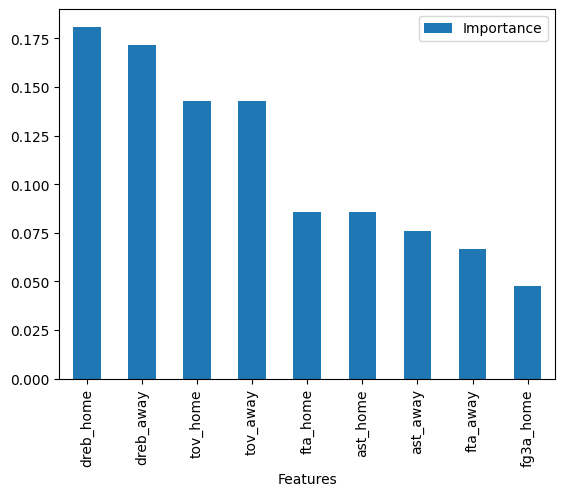

In [69]:
from src.notebook_functions import feature_importance_tree_based_models, find_features


kept, _ = find_features(X_TrainSet, ada_pipe, TO_DROP)
X = X_TrainSet.filter(kept)
ada_model = ada_pipe["model"]
feature_importance_tree_based_models(model=ada_model, columns=X.columns)

This model also finds that the most important predictor of winning is defensive rebounds and turnovers.

Now we will fit our pipeline after dropping all but the above features. This will be our final model.

In [74]:
stats = ["dreb", "tov", "ast", "fta"]
home_features = [term + "_home" for term in stats]
away_features = [term + "_away" for term in stats]
features = home_features + away_features + ["fg3a_home"]
to_drop = [feature for feature in X_TrainSet.columns if feature not in features]

TRANSFORMS = {
    "box_cox": (vt.BoxCoxTransformer, False),
    "yeo_johnson": (vt.YeoJohnsonTransformer, False),
}
TRANSFORM_ASSIGNMENTS = {
    "yeo_johnson": [
        "dreb_away",
        "blk_home",
        "oreb_away",
        "fta_away",
        "dreb_home",
        "ast_home",
        "stl_away",
        "stl_home",
        "reb_away",
        "oreb_home",
        "pf_away",
        "pf_home",
    ],
    "box_cox": ["ast_away", "fta_home"],
}


new_assignments = {
    key: [val for val in value if val not in to_drop]
    for key, value in TRANSFORM_ASSIGNMENTS.items()
}

final_ada_pipe = Pipeline([("dropper", DropFeatures(features_to_drop=TO_DROP))])

for transform, targets in new_assignments.items():
    if not targets:
        continue
    final_ada_pipe.steps.append(
        (transform, TRANSFORMS[transform][0](variables=targets))
    )
final_ada_pipe.steps.append(("scaler", StandardScaler()))
final_ada_pipe.steps.append(
    (
        "model",
        AdaBoostClassifier(
            n_estimators=105, learning_rate=1, algorithm="SAMME.R", random_state=42
        ),
    )
)


final_ada_pipe.fit(X_TrainSet, y_TrainSet)
clf_performance(
    X_TrainSet,
    y_TrainSet,
    X_TestSet,
    y_TestSet,
    final_logistic_pipe,
    label_map=["loss", "win"],
)
clf_performance(
    X_TrainSet,
    y_TrainSet,
    X_TestSet,
    y_TestSet,
    final_ada_pipe,
    label_map=["loss", "win"],
)
print(final_ada_pipe.steps)
print(final_logistic_pipe.steps)

#### Train Set #### 

---  Confusion Matrix  ---
                Actual loss Actual win
Prediction loss       11401       2288
Prediction win         1922      19265


---  Classification Report  ---
              precision    recall  f1-score   support

        loss       0.86      0.83      0.84     13689
         win       0.89      0.91      0.90     21187

    accuracy                           0.88     34876
   macro avg       0.87      0.87      0.87     34876
weighted avg       0.88      0.88      0.88     34876
 

#### Test Set ####

---  Confusion Matrix  ---
                Actual loss Actual win
Prediction loss        2886        605
Prediction win          450       4778


---  Classification Report  ---
              precision    recall  f1-score   support

        loss       0.87      0.83      0.85      3491
         win       0.89      0.91      0.90      5228

    accuracy                           0.88      8719
   macro avg       0.88      0.87      0.87      8719
w

Our Logistic Regression performs a bit better. But both models meet our criteria of 75% average precision and 70% accuracy.

---

## Conclusion
We have constructed two models that exceed our business requirements. On unseen data, they score:
* Logistic Regression:
  * Avg. Precision: 88%
  * Accuracy: 88%
* Adaptive Boost:
  * Avg. Precision: 86.5%
  * Accuracy: 87%

We have satisfied Business requirement 2 by producing these models. We have also validated Hypothesis 3, that we can construct such models without using statistics like points and made shots.

Let's finish by saving our models.

In [72]:
# taken from Churnometer walkthrough project
version = 'v1'
file_path = f'outputs/ml_pipeline/predict_home_wins/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

joblib.dump(value=final_logistic_pipe, filename=f"{file_path}/logistic_pipeline.pkl")
joblib.dump(value=final_ada_pipe, filename=f"{file_path}/ada_pipeline.pkl")


['outputs/ml_pipeline/predict_home_wins/v1/ada_pipeline.pkl']



## Next Steps
In the next notebook we will do some clustering analysis of our data to determine if the statistics correlate with time.